In [1]:
%load_ext autoreload
%autoreload 2
     
import torch
import os
from matplotlib import pyplot as plt
from csng.brainreader_mouse.data import get_brainreader_mouse_dataloaders

import os
import torch

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from csng.imagenet.models import ReadIn, ResnetExtractor, UpsampleModel, count_parameters
import datetime

assert torch.cuda.is_available()

Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [2]:

device = os.environ["DEVICE"]
DATA_PATH = os.environ['DATA_PATH']
CACHE_DIR = os.path.join(DATA_PATH, 'brainreader_cache')
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, 'brainreader')

BATCH_SIZE = 64
EPOCHS = 80
WEIGHT_DECAY=0e-4
LEARNING_RATE = .0002* BATCH_SIZE
READIN_DTYPE = torch.bfloat16
MODEL_PATH = '/scratch/izar/vanousek/cs-433-project/models/'
RESNET_DECODE_MODEL = os.path.join(MODEL_PATH, 'mlp2489100.pt')

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [3]:
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "save_path": os.path.join(DATA_PATH, "models", "encoder_ball_50.pt"),
    # "load_ckpt": os.path.join(DATA_PATH, "models", "encoder_ball.pt"),
    "train": True,
}
config["data"]["brainreader_mouse"] = {
    "device": config["device"],
    "mixing_strategy": config["data"]["mixing_strategy"],
    "max_batches": None,
    "data_dir": os.path.join(DATA_PATH_BRAINREADER, "data"),
    "batch_size": BATCH_SIZE,
    # "sessions": list(range(1, 23)),
    "sessions": [6],
    "resize_stim_to": (224, 224),
    "normalize_stim": False,
    "normalize_resp": True,
    "div_resp_by_std": True,
    "clamp_neg_resp": True,
    "additional_keys": None,
    "avg_test_resp": True,
}

dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
print(len(dl['train']), len(dl['test']))

71 1


1
torch.Size([64, 1, 224, 224])
torch.Size([64, 8587])
6


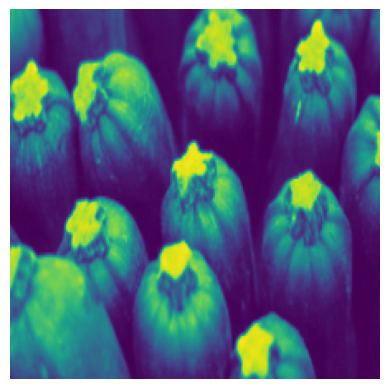

In [4]:
def show_image(img_tensor, title=''):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

items = next(dl['train'])
print(len(items))
item = items[0]
stim = item['stim']
print(stim.shape)

resp = item['resp']
print(resp.shape)
neurons = resp.shape[1]
data_key = item['data_key']
print(data_key)
# plot the stim as grayscale image with matplotlib
show_image(stim[0]) 


In [5]:
readin = ReadIn(neurons, (1024, 14, 14))
readin.to(device, dtype=READIN_DTYPE)
    

params = count_parameters(readin)
print("Total parametrs: ", params)


Total parametrs:  220345344


In [6]:

optimizer = torch.optim.Adam(readin.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(dl['train'])*EPOCHS, eta_min=LEARNING_RATE/5)

extractor = ResnetExtractor()

losses = []


for epoch in range(EPOCHS):
    dl = get_brainreader_mouse_dataloaders(config=config["data"]["brainreader_mouse"])['brainreader_mouse']
    for minibatch in tqdm(dl['train']):
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)

        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        
        with torch.cuda.amp.autocast():
            pass
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)
        output = readin(resp)
        loss = criterion(output, target)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(readin.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)
        losses.append(relative_loss)
        # print(f"Loss: {loss.item()} Constant loss: {constant_loss} Relative loss: {relative_loss}")

        optimizer.zero_grad()
    print(f"Epoch {epoch} finished with relative loss {np.mean(losses[-len(dl['train']):])}")



Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


  0%|          | 0/71 [00:00<?, ?it/s]

/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 64, 1024, 14, 14])) that is different to the input size (torch.Size([64, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  1%|▏         | 1/71 [00:06<07:22,  6.32s/it]

  3%|▎         | 2/71 [00:07<03:58,  3.46s/it]

  4%|▍         | 3/71 [00:09<02:58,  2.63s/it]

  6%|▌         | 4/71 [00:10<02:23,  2.14s/it]

  7%|▋         | 5/71 [00:12<02:03,  1.87s/it]

  8%|▊         | 6/71 [00:13<01:50,  1.70s/it]

 10%|▉         | 7/71 [00:15<01:44,  1.63s/it]

 11%|█▏        | 8/71 [00:16<01:35,  1.52s/it]

 13%|█▎        | 9/71 [00:17<01:29,  1.45s/it]

 14%|█▍        | 10/71 [00:18<01:25,  1.40s/it]

 15%|█▌        | 11/71 [00:20<01:21,  1.36s/it]

 17%|█▋        | 12/71 [00:21<01:19,  1.35s/it]

 18%|█▊        | 13/71 [00:22<01:14,  1.28s/it]

 20%|█▉        | 14/71 [00:23<01:13,  1.28s/it]

 21%|██        | 15/71 [00:25<01:12,  1.29s/it]

 23%|██▎       | 16/71 [00:26<01:13,  1.34s/it]

 24%|██▍       | 17/71 [00:28<01:12,  1.33s/it]

 25%|██▌       | 18/71 [00:29<01:08,  1.29s/it]

 27%|██▋       | 19/71 [00:30<01:06,  1.27s/it]

 28%|██▊       | 20/71 [00:31<01:03,  1.25s/it]

 30%|██▉       | 21/71 [00:32<01:00,  1.21s/it]

 31%|███       | 22/71 [00:34<00:59,  1.22s/it]

 32%|███▏      | 23/71 [00:35<00:56,  1.19s/it]

 34%|███▍      | 24/71 [00:36<00:56,  1.20s/it]

 35%|███▌      | 25/71 [00:37<00:55,  1.21s/it]

 37%|███▋      | 26/71 [00:38<00:54,  1.20s/it]

 38%|███▊      | 27/71 [00:40<00:53,  1.21s/it]

 39%|███▉      | 28/71 [00:41<00:51,  1.20s/it]

 41%|████      | 29/71 [00:42<00:51,  1.22s/it]

 42%|████▏     | 30/71 [00:43<00:48,  1.19s/it]

 44%|████▎     | 31/71 [00:44<00:48,  1.20s/it]

 45%|████▌     | 32/71 [00:45<00:43,  1.13s/it]

 46%|████▋     | 33/71 [00:46<00:42,  1.13s/it]

 48%|████▊     | 34/71 [00:47<00:40,  1.10s/it]

 49%|████▉     | 35/71 [00:49<00:40,  1.12s/it]

 51%|█████     | 36/71 [00:50<00:38,  1.10s/it]

 52%|█████▏    | 37/71 [00:51<00:38,  1.13s/it]

 54%|█████▎    | 38/71 [00:52<00:37,  1.14s/it]

 55%|█████▍    | 39/71 [00:53<00:35,  1.12s/it]

 56%|█████▋    | 40/71 [00:54<00:33,  1.10s/it]

 58%|█████▊    | 41/71 [00:55<00:32,  1.09s/it]

 59%|█████▉    | 42/71 [00:56<00:30,  1.05s/it]

 61%|██████    | 43/71 [00:57<00:29,  1.04s/it]

 62%|██████▏   | 44/71 [00:58<00:27,  1.02s/it]

 63%|██████▎   | 45/71 [00:59<00:26,  1.02s/it]

 65%|██████▍   | 46/71 [01:00<00:26,  1.08s/it]

 66%|██████▌   | 47/71 [01:01<00:25,  1.06s/it]

 68%|██████▊   | 48/71 [01:02<00:23,  1.04s/it]

 69%|██████▉   | 49/71 [01:03<00:22,  1.01s/it]

 70%|███████   | 50/71 [01:04<00:20,  1.01it/s]

 72%|███████▏  | 51/71 [01:05<00:19,  1.02it/s]

 73%|███████▎  | 52/71 [01:06<00:18,  1.02it/s]

 75%|███████▍  | 53/71 [01:07<00:17,  1.03it/s]

 76%|███████▌  | 54/71 [01:08<00:17,  1.02s/it]

 77%|███████▋  | 55/71 [01:09<00:15,  1.02it/s]

 79%|███████▉  | 56/71 [01:10<00:14,  1.04it/s]

 80%|████████  | 57/71 [01:11<00:13,  1.07it/s]

 82%|████████▏ | 58/71 [01:12<00:12,  1.06it/s]

 83%|████████▎ | 59/71 [01:13<00:12,  1.01s/it]

 85%|████████▍ | 60/71 [01:14<00:10,  1.01it/s]

 86%|████████▌ | 61/71 [01:15<00:09,  1.01it/s]

 87%|████████▋ | 62/71 [01:16<00:08,  1.03it/s]

 89%|████████▊ | 63/71 [01:17<00:08,  1.02s/it]

 90%|█████████ | 64/71 [01:18<00:07,  1.08s/it]

 92%|█████████▏| 65/71 [01:19<00:06,  1.01s/it]

 93%|█████████▎| 66/71 [01:20<00:04,  1.04it/s]

 94%|█████████▍| 67/71 [01:21<00:03,  1.03it/s]

 96%|█████████▌| 68/71 [01:22<00:02,  1.06it/s]

 97%|█████████▋| 69/71 [01:23<00:01,  1.04it/s]

 99%|█████████▊| 70/71 [01:24<00:00,  1.08it/s]

/home/vanousek/miniconda3/envs/csng/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 20, 1024, 14, 14])) that is different to the input size (torch.Size([20, 1024, 14, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 71/71 [01:24<00:00,  1.33it/s]

100%|██████████| 71/71 [01:24<00:00,  1.19s/it]

Epoch 0 finished with relative loss 3.9438287472179416


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.36it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.34it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.34it/s]

  6%|▌         | 4/71 [00:01<00:20,  3.34it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.35it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.35it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.35it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.34it/s]

 21%|██        | 15/71 [00:04<00:16,  3.34it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.34it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.34it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.33it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.34it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.34it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.34it/s]

 31%|███       | 22/71 [00:06<00:14,  3.34it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.34it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.34it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.34it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.35it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.35it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.35it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.35it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.34it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.34it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.34it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.35it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.35it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.35it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.35it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.35it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:21<00:00,  4.13it/s]

100%|██████████| 71/71 [00:21<00:00,  3.38it/s]

Epoch 1 finished with relative loss 0.3939749188193679


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.36it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.35it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.34it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.34it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.35it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.34it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.34it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.35it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.35it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.34it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.35it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.35it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.35it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.35it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.35it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.35it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.35it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.35it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.35it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.35it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.34it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.34it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.34it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.34it/s]

100%|██████████| 71/71 [00:21<00:00,  4.12it/s]

100%|██████████| 71/71 [00:21<00:00,  3.38it/s]

Epoch 2 finished with relative loss 0.2343814350226985


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.35it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.35it/s]

  6%|▌         | 4/71 [00:01<00:20,  3.35it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.35it/s]

  8%|▊         | 6/71 [00:01<00:22,  2.92it/s]

 10%|▉         | 7/71 [00:02<00:20,  3.05it/s]

 11%|█▏        | 8/71 [00:02<00:20,  3.14it/s]

 13%|█▎        | 9/71 [00:02<00:19,  3.19it/s]

 14%|█▍        | 10/71 [00:03<00:18,  3.23it/s]

 15%|█▌        | 11/71 [00:03<00:18,  3.27it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.29it/s]

 18%|█▊        | 13/71 [00:04<00:17,  3.31it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.32it/s]

 21%|██        | 15/71 [00:04<00:16,  3.33it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.33it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.34it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.34it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:06<00:15,  3.34it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.34it/s]

 31%|███       | 22/71 [00:06<00:14,  3.34it/s]

 32%|███▏      | 23/71 [00:07<00:14,  3.34it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.34it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.34it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.35it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.35it/s]

 42%|████▏     | 30/71 [00:09<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:12<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.34it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.34it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.34it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.34it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.35it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.35it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.35it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:15<00:06,  3.35it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:18<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.35it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.35it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.35it/s]

 99%|█████████▊| 70/71 [00:21<00:00,  3.35it/s]

100%|██████████| 71/71 [00:21<00:00,  4.14it/s]

100%|██████████| 71/71 [00:21<00:00,  3.36it/s]

Epoch 3 finished with relative loss 0.2255409023539871


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.35it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.35it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.35it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.34it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.34it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.34it/s]

 41%|████      | 29/71 [00:08<00:12,  3.34it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.35it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.35it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.35it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.35it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.35it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.35it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.35it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.35it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.35it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.14it/s]

100%|██████████| 71/71 [00:20<00:00,  3.38it/s]

Epoch 4 finished with relative loss 0.21892328546026524


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.35it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.35it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.35it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.35it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.35it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.35it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.33it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.34it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.34it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.35it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.35it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.35it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:08,  2.96it/s]

 65%|██████▍   | 46/71 [00:13<00:08,  3.07it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.15it/s]

 68%|██████▊   | 48/71 [00:14<00:07,  3.21it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.25it/s]

 70%|███████   | 50/71 [00:15<00:06,  3.28it/s]

 72%|███████▏  | 51/71 [00:15<00:06,  3.30it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.31it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.32it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.33it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.34it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.32it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.33it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.33it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.33it/s]

 85%|████████▍ | 60/71 [00:18<00:03,  3.33it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.34it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.35it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.35it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:21<00:00,  3.36it/s]

100%|██████████| 71/71 [00:21<00:00,  4.14it/s]

100%|██████████| 71/71 [00:21<00:00,  3.36it/s]

Epoch 5 finished with relative loss 0.21296375452438007


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.35it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.35it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.35it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.35it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.35it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.35it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.35it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.35it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.35it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.35it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.35it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.35it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.35it/s]

100%|██████████| 71/71 [00:20<00:00,  4.14it/s]

100%|██████████| 71/71 [00:20<00:00,  3.38it/s]

Epoch 6 finished with relative loss 0.2070048590032888


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.35it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.35it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.33it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.33it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.34it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.34it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.34it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.35it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.35it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.35it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.35it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.35it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.14it/s]

100%|██████████| 71/71 [00:20<00:00,  3.38it/s]

Epoch 7 finished with relative loss 0.2015528901008956


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.36it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.35it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.35it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:15,  2.96it/s]

 38%|███▊      | 27/71 [00:08<00:14,  3.07it/s]

 39%|███▉      | 28/71 [00:08<00:13,  3.14it/s]

 41%|████      | 29/71 [00:08<00:13,  3.20it/s]

 42%|████▏     | 30/71 [00:09<00:12,  3.23it/s]

 44%|████▎     | 31/71 [00:09<00:12,  3.27it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.30it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.31it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.32it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.33it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.34it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.34it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.35it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:12<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.34it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.34it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.32it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.33it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.33it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.34it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.34it/s]

 70%|███████   | 50/71 [00:15<00:06,  3.34it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.35it/s]

 85%|████████▍ | 60/71 [00:18<00:03,  3.35it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.35it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.35it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.35it/s]

 99%|█████████▊| 70/71 [00:21<00:00,  3.35it/s]

100%|██████████| 71/71 [00:21<00:00,  4.14it/s]

100%|██████████| 71/71 [00:21<00:00,  3.36it/s]

Epoch 8 finished with relative loss 0.19588126788683224


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.34it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.33it/s]

  6%|▌         | 4/71 [00:01<00:20,  3.34it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.35it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.34it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.34it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.35it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.35it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.35it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.34it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.34it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.34it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.34it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.34it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.34it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.35it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.34it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.33it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.34it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.34it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.35it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.35it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.35it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.34it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.34it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.35it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.34it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.35it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.35it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.35it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.35it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.35it/s]

100%|██████████| 71/71 [00:21<00:00,  4.14it/s]

100%|██████████| 71/71 [00:21<00:00,  3.38it/s]

Epoch 9 finished with relative loss 0.19092838293393646


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:20,  3.35it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.34it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.34it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.34it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.34it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.35it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.35it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.35it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.34it/s]

 41%|████      | 29/71 [00:08<00:12,  3.34it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.34it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.35it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.35it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.35it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.35it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:18<00:03,  3.00it/s]

 86%|████████▌ | 61/71 [00:18<00:03,  3.09it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.17it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.22it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.26it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.29it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.31it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.32it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.33it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.34it/s]

 99%|█████████▊| 70/71 [00:21<00:00,  3.35it/s]

100%|██████████| 71/71 [00:21<00:00,  4.13it/s]

100%|██████████| 71/71 [00:21<00:00,  3.36it/s]

Epoch 10 finished with relative loss 0.186448947956564


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.35it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.35it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.35it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.35it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.35it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.35it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.35it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.35it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.35it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.34it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.34it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.33it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.34it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.34it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.35it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.35it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.34it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.33it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.33it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.33it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.34it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.34it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.34it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.34it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.34it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.34it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.35it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.35it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.34it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.35it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.35it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.35it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.35it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.35it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.35it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.35it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.35it/s]

100%|██████████| 71/71 [00:21<00:00,  4.14it/s]

100%|██████████| 71/71 [00:21<00:00,  3.38it/s]

Epoch 11 finished with relative loss 0.18187656521934195


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.35it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.35it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.35it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.35it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.35it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.34it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.34it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.34it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.35it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.35it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.35it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.35it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.35it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.35it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.35it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.35it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.34it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.35it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.35it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.35it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.35it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.35it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.34it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.34it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.35it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.35it/s]

100%|██████████| 71/71 [00:21<00:00,  4.13it/s]

100%|██████████| 71/71 [00:21<00:00,  3.38it/s]

Epoch 12 finished with relative loss 0.17682058610407084


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.35it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.35it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.35it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.35it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.35it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.35it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.35it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.34it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.35it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.35it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.35it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:10,  2.96it/s]

 59%|█████▉    | 42/71 [00:12<00:09,  3.06it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.14it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.19it/s]

 63%|██████▎   | 45/71 [00:13<00:08,  3.24it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.27it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.29it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.30it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.30it/s]

 70%|███████   | 50/71 [00:15<00:06,  3.32it/s]

 72%|███████▏  | 51/71 [00:15<00:06,  3.33it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.33it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.33it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.34it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.33it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.32it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.33it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.34it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.35it/s]

 85%|████████▍ | 60/71 [00:18<00:03,  3.34it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.35it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:21<00:00,  3.35it/s]

100%|██████████| 71/71 [00:21<00:00,  4.13it/s]

100%|██████████| 71/71 [00:21<00:00,  3.36it/s]

Epoch 13 finished with relative loss 0.17185496650612814


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.36it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.35it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.35it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.35it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.34it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.33it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.34it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.34it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.35it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.34it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.34it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.34it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.34it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.34it/s]

 41%|████      | 29/71 [00:08<00:12,  3.33it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.34it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.34it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.34it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.35it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.35it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.35it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.35it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.35it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.34it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.34it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.35it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.34it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.35it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.35it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.35it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.35it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.35it/s]

100%|██████████| 71/71 [00:21<00:00,  4.14it/s]

100%|██████████| 71/71 [00:21<00:00,  3.38it/s]

Epoch 14 finished with relative loss 0.16737283934898134


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.35it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.34it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.35it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.34it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.35it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.35it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.35it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.35it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.35it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.35it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.34it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.34it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.34it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.35it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.34it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.34it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.34it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.35it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.00it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.10it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.17it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.22it/s]

100%|██████████| 71/71 [00:21<00:00,  4.00it/s]

100%|██████████| 71/71 [00:21<00:00,  3.36it/s]

Epoch 15 finished with relative loss 0.1627841886401263


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.39it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.37it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.35it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.35it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.35it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.35it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.14it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 16 finished with relative loss 0.1586206801534806


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.34it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.35it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.35it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.14it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 17 finished with relative loss 0.15484340778779287


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.35it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.35it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:15,  3.00it/s]

 35%|███▌      | 25/71 [00:07<00:14,  3.10it/s]

 37%|███▋      | 26/71 [00:07<00:14,  3.17it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.23it/s]

 39%|███▉      | 28/71 [00:08<00:13,  3.27it/s]

 41%|████      | 29/71 [00:08<00:12,  3.30it/s]

 42%|████▏     | 30/71 [00:09<00:12,  3.32it/s]

 44%|████▎     | 31/71 [00:09<00:12,  3.33it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.34it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:12<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.35it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:15<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.37it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.37it/s]

100%|██████████| 71/71 [00:21<00:00,  4.15it/s]

100%|██████████| 71/71 [00:21<00:00,  3.37it/s]

Epoch 18 finished with relative loss 0.15084897954448465


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.35it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.37it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.37it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.37it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.37it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.37it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.37it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.37it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.37it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.35it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.35it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.14it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 19 finished with relative loss 0.14736551405288786


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.34it/s]

  6%|▌         | 4/71 [00:01<00:20,  3.34it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.34it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.35it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.34it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.35it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.35it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.35it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.35it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.35it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.35it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.35it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.35it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.13it/s]

100%|██████████| 71/71 [00:20<00:00,  3.38it/s]

Epoch 20 finished with relative loss 0.14378570819564812


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:22,  2.93it/s]

  8%|▊         | 6/71 [00:01<00:21,  3.06it/s]

 10%|▉         | 7/71 [00:02<00:20,  3.15it/s]

 11%|█▏        | 8/71 [00:02<00:19,  3.21it/s]

 13%|█▎        | 9/71 [00:02<00:19,  3.26it/s]

 14%|█▍        | 10/71 [00:03<00:18,  3.29it/s]

 15%|█▌        | 11/71 [00:03<00:18,  3.31it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.32it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.34it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.34it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.33it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.34it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.34it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:06<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:09<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.35it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.31it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.32it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.33it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.33it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.34it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.34it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:12<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.34it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.35it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.35it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.35it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:15<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:18<00:03,  3.35it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.35it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.35it/s]

 99%|█████████▊| 70/71 [00:21<00:00,  3.35it/s]

100%|██████████| 71/71 [00:21<00:00,  4.14it/s]

100%|██████████| 71/71 [00:21<00:00,  3.36it/s]

Epoch 21 finished with relative loss 0.13990870242789277


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.35it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.35it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.35it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.35it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.35it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.35it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.35it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.35it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.35it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.35it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.35it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.35it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.35it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.35it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.35it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.33it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.33it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.33it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.33it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.34it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.34it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.35it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.35it/s]

100%|██████████| 71/71 [00:21<00:00,  4.13it/s]

100%|██████████| 71/71 [00:21<00:00,  3.38it/s]

Epoch 22 finished with relative loss 0.13693427585208479


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.35it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.34it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.34it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.35it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.35it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.35it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.35it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.35it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:05,  3.00it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.10it/s]

 82%|████████▏ | 58/71 [00:17<00:04,  3.17it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.22it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.26it/s]

 86%|████████▌ | 61/71 [00:18<00:03,  3.29it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.31it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.32it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.33it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.34it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.35it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.34it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.35it/s]

100%|██████████| 71/71 [00:21<00:00,  4.13it/s]

100%|██████████| 71/71 [00:21<00:00,  3.37it/s]

Epoch 23 finished with relative loss 0.13385738360189312


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.35it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.35it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.35it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.35it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.35it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.35it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.34it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.35it/s]

100%|██████████| 71/71 [00:20<00:00,  4.14it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 24 finished with relative loss 0.13102027412225792


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.37it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.34it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.35it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.35it/s]

100%|██████████| 71/71 [00:20<00:00,  4.14it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 25 finished with relative loss 0.12817711623635356


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.37it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.37it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.37it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:18,  3.03it/s]

 24%|██▍       | 17/71 [00:05<00:17,  3.12it/s]

 25%|██▌       | 18/71 [00:05<00:16,  3.19it/s]

 27%|██▋       | 19/71 [00:05<00:16,  3.24it/s]

 28%|██▊       | 20/71 [00:06<00:15,  3.27it/s]

 30%|██▉       | 21/71 [00:06<00:15,  3.30it/s]

 31%|███       | 22/71 [00:06<00:14,  3.32it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.32it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.34it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.34it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.35it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:09<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.35it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.37it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:12<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.37it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.37it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.37it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.37it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:21<00:00,  4.15it/s]

100%|██████████| 71/71 [00:21<00:00,  3.37it/s]

Epoch 26 finished with relative loss 0.1252816029814786


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.36it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.37it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.37it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.37it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.37it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.37it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.37it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.37it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.37it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.37it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.37it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.37it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.35it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.15it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 27 finished with relative loss 0.12307737133374097


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.39it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.38it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.37it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.37it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.35it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.35it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.37it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  2.97it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.08it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.16it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.21it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.26it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.29it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.31it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.32it/s]

100%|██████████| 71/71 [00:21<00:00,  4.11it/s]

100%|██████████| 71/71 [00:21<00:00,  3.37it/s]

Epoch 28 finished with relative loss 0.12026146927101185


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.37it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.37it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.37it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.37it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.37it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.15it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 29 finished with relative loss 0.11765224467531665


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.35it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.35it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.35it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.35it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.35it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.33it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.34it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.34it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.35it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.35it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.35it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.35it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.14it/s]

100%|██████████| 71/71 [00:20<00:00,  3.38it/s]

Epoch 30 finished with relative loss 0.11544210056011554


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.35it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.37it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.35it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.35it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.35it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.34it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.34it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.35it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.35it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.02it/s]

 63%|██████▎   | 45/71 [00:13<00:08,  3.12it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.19it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.23it/s]

 68%|██████▊   | 48/71 [00:14<00:07,  3.27it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.29it/s]

 70%|███████   | 50/71 [00:15<00:06,  3.31it/s]

 72%|███████▏  | 51/71 [00:15<00:06,  3.32it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.34it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.34it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.34it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.34it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.35it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.35it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.35it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.35it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.35it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:21<00:00,  4.14it/s]

100%|██████████| 71/71 [00:21<00:00,  3.37it/s]

Epoch 31 finished with relative loss 0.11350359763937007


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.39it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.35it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.35it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.35it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.35it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.35it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.35it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.15it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 32 finished with relative loss 0.11144855932275816


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.34it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.35it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.35it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.35it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.35it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.35it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.35it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.37it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.37it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.14it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 33 finished with relative loss 0.10922880720024784


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:23,  2.88it/s]

  7%|▋         | 5/71 [00:01<00:21,  3.04it/s]

  8%|▊         | 6/71 [00:01<00:20,  3.13it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.20it/s]

 11%|█▏        | 8/71 [00:02<00:19,  3.25it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.28it/s]

 14%|█▍        | 10/71 [00:03<00:18,  3.31it/s]

 15%|█▌        | 11/71 [00:03<00:18,  3.32it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.33it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.34it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.34it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:06<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.34it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.34it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.35it/s]

 42%|████▏     | 30/71 [00:09<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.35it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.35it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.35it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:12<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.35it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.35it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.35it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:15<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.35it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:18<00:03,  3.35it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.35it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.34it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.33it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.33it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.32it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.32it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.32it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.32it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.32it/s]

 99%|█████████▊| 70/71 [00:21<00:00,  3.33it/s]

100%|██████████| 71/71 [00:21<00:00,  4.11it/s]

100%|██████████| 71/71 [00:21<00:00,  3.36it/s]

Epoch 34 finished with relative loss 0.10787286897111847


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.35it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.34it/s]

  6%|▌         | 4/71 [00:01<00:20,  3.33it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.32it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.32it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.33it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.33it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.33it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.34it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.34it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.34it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.34it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.35it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.35it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.35it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.35it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.35it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.34it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.35it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.34it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.35it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.35it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.35it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.35it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.34it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.33it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.33it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.34it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.34it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.33it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.34it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.34it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.34it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.34it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.35it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.35it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.35it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.35it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.35it/s]

100%|██████████| 71/71 [00:21<00:00,  4.13it/s]

100%|██████████| 71/71 [00:21<00:00,  3.38it/s]

Epoch 35 finished with relative loss 0.10610671901539248


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.36it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.35it/s]

  6%|▌         | 4/71 [00:01<00:20,  3.35it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.35it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.35it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.35it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.34it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.35it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.35it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.34it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.34it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.34it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.34it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.34it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.35it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.34it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.35it/s]

 41%|████      | 29/71 [00:08<00:12,  3.35it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.34it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.34it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.34it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.35it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.34it/s]

 55%|█████▍    | 39/71 [00:11<00:10,  2.99it/s]

 56%|█████▋    | 40/71 [00:12<00:10,  3.09it/s]

 58%|█████▊    | 41/71 [00:12<00:09,  3.16it/s]

 59%|█████▉    | 42/71 [00:12<00:09,  3.22it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.25it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.28it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.30it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.32it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.32it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.33it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.34it/s]

 70%|███████   | 50/71 [00:15<00:06,  3.34it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.34it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.34it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.34it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.34it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.34it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.34it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.35it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.35it/s]

 85%|████████▍ | 60/71 [00:18<00:03,  3.35it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.35it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.35it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.35it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.35it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.35it/s]

 99%|█████████▊| 70/71 [00:21<00:00,  3.35it/s]

100%|██████████| 71/71 [00:21<00:00,  4.14it/s]

100%|██████████| 71/71 [00:21<00:00,  3.36it/s]

Epoch 36 finished with relative loss 0.10436866816103703


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.35it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.35it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.34it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.35it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.37it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.15it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 37 finished with relative loss 0.10273901978235175


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.39it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.37it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.34it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.34it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.35it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.14it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 38 finished with relative loss 0.10148076238583219


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:06<00:17,  2.99it/s]

 30%|██▉       | 21/71 [00:06<00:16,  3.09it/s]

 31%|███       | 22/71 [00:06<00:15,  3.17it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.22it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.26it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.29it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.32it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.33it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.34it/s]

 41%|████      | 29/71 [00:08<00:12,  3.35it/s]

 42%|████▏     | 30/71 [00:09<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.35it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:12<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.35it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.35it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:21<00:00,  4.14it/s]

100%|██████████| 71/71 [00:21<00:00,  3.37it/s]

Epoch 39 finished with relative loss 0.0996268037564646


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.35it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.34it/s]

  6%|▌         | 4/71 [00:01<00:20,  3.34it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.35it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.35it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.35it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.37it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.35it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.37it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.37it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.37it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.37it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.37it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.14it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 40 finished with relative loss 0.09858042912317129


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.35it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.35it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.35it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.37it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.35it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.35it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.35it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.35it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:04,  3.02it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.11it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.18it/s]

 86%|████████▌ | 61/71 [00:18<00:03,  3.23it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.27it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.30it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.32it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.33it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.34it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.35it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.35it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.35it/s]

100%|██████████| 71/71 [00:21<00:00,  4.14it/s]

100%|██████████| 71/71 [00:21<00:00,  3.37it/s]

Epoch 41 finished with relative loss 0.09714149211460785


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.39it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.37it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.37it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.35it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.35it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.34it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.34it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.35it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.35it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.35it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.15it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 42 finished with relative loss 0.09555723624170875


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.34it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.35it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.37it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.35it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.37it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.37it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.37it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.37it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.37it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.37it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.37it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.37it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.37it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.14it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 43 finished with relative loss 0.09460940157425222


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.37it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.37it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.35it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.35it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:10,  2.98it/s]

 56%|█████▋    | 40/71 [00:12<00:10,  3.09it/s]

 58%|█████▊    | 41/71 [00:12<00:09,  3.17it/s]

 59%|█████▉    | 42/71 [00:12<00:09,  3.22it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.26it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.29it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.31it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.33it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.34it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.35it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:15<00:06,  3.35it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:21<00:00,  4.14it/s]

100%|██████████| 71/71 [00:21<00:00,  3.37it/s]

Epoch 44 finished with relative loss 0.09366609286840011


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.37it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.37it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.37it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.37it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.37it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.34it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.34it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.35it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.35it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.35it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.37it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.37it/s]

100%|██████████| 71/71 [00:20<00:00,  4.16it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 45 finished with relative loss 0.0927513628347424


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.36it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.37it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.37it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.37it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.37it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.35it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.37it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.37it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.37it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.37it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.37it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.37it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.37it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.37it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.37it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.37it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.37it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.37it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.37it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.37it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.03it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.12it/s]

100%|██████████| 71/71 [00:21<00:00,  3.89it/s]

100%|██████████| 71/71 [00:21<00:00,  3.38it/s]

Epoch 46 finished with relative loss 0.09143268437014779


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.37it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.37it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.37it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.37it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.37it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.37it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.35it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.35it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.34it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.37it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.37it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.37it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.37it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.37it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.37it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.37it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.37it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.37it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.37it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.37it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.37it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.37it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.37it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.37it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.37it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.37it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.37it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.37it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.37it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.15it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 47 finished with relative loss 0.09062827628535991


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.39it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.38it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.38it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.37it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.37it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.37it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.37it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.37it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.37it/s]

 31%|███       | 22/71 [00:06<00:14,  3.37it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.37it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.37it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.37it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.37it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.37it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.37it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.37it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.37it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.35it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.35it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.34it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.35it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.35it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.36it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.37it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.37it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.37it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.37it/s]

100%|██████████| 71/71 [00:20<00:00,  4.16it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 48 finished with relative loss 0.08945036904491362


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.37it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.37it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.36it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.37it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.37it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.37it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.36it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.37it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.37it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.37it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.37it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.37it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:15,  2.98it/s]

 38%|███▊      | 27/71 [00:08<00:14,  3.09it/s]

 39%|███▉      | 28/71 [00:08<00:13,  3.16it/s]

 41%|████      | 29/71 [00:08<00:13,  3.22it/s]

 42%|████▏     | 30/71 [00:09<00:12,  3.26it/s]

 44%|████▎     | 31/71 [00:09<00:12,  3.29it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.32it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.33it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.34it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.35it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.35it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.35it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:12<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.37it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.36it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.37it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.37it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.37it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.37it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.37it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.37it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.37it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.37it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.37it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.37it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.37it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.37it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.37it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.37it/s]

100%|██████████| 71/71 [00:21<00:00,  4.16it/s]

100%|██████████| 71/71 [00:21<00:00,  3.38it/s]

Epoch 49 finished with relative loss 0.08901354432612069


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.39it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.34it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.34it/s]

  6%|▌         | 4/71 [00:01<00:20,  3.35it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.36it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.37it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.37it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.37it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.37it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.37it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.37it/s]

 31%|███       | 22/71 [00:06<00:14,  3.37it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.37it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.37it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.37it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.37it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.37it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.37it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.37it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.37it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.37it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.37it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.37it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.37it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.37it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.37it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.37it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.37it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.37it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.37it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.37it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.37it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.37it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.37it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.37it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.37it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.37it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.37it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.37it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.37it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.37it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.37it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.37it/s]

100%|██████████| 71/71 [00:20<00:00,  4.16it/s]

100%|██████████| 71/71 [00:20<00:00,  3.40it/s]

Epoch 50 finished with relative loss 0.08806560446042822


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.38it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.37it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.37it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.36it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.37it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.37it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.37it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.37it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.37it/s]

 21%|██        | 15/71 [00:04<00:16,  3.37it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.37it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.37it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.37it/s]

 31%|███       | 22/71 [00:06<00:14,  3.37it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.37it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.37it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.37it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.37it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.37it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.35it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.35it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.35it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.36it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.37it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.37it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.37it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.37it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.37it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.37it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.37it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.37it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.37it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.37it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.37it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.37it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.37it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.37it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.37it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.37it/s]

100%|██████████| 71/71 [00:20<00:00,  4.15it/s]

100%|██████████| 71/71 [00:20<00:00,  3.40it/s]

Epoch 51 finished with relative loss 0.087146517293743


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.39it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.37it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.37it/s]

 10%|▉         | 7/71 [00:02<00:21,  3.01it/s]

 11%|█▏        | 8/71 [00:02<00:20,  3.11it/s]

 13%|█▎        | 9/71 [00:02<00:19,  3.19it/s]

 14%|█▍        | 10/71 [00:03<00:18,  3.24it/s]

 15%|█▌        | 11/71 [00:03<00:18,  3.28it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.31it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.32it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.33it/s]

 21%|██        | 15/71 [00:04<00:16,  3.34it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.35it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:06<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.35it/s]

 31%|███       | 22/71 [00:06<00:14,  3.35it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.37it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:09<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.37it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.37it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.37it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.37it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.37it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.37it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.37it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.37it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.37it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.37it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.37it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.37it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.37it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.37it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.37it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.37it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.37it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.37it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.37it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.37it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.37it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.37it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.37it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.35it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:21<00:00,  4.15it/s]

100%|██████████| 71/71 [00:21<00:00,  3.38it/s]

Epoch 52 finished with relative loss 0.08663763562369904


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.39it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.37it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.37it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.37it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.36it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.37it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.35it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.37it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.37it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:14,  3.33it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.34it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.35it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.36it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.37it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.37it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.37it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.37it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.37it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.37it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.37it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.37it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.37it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.37it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.37it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.37it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.37it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.37it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.37it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.37it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.37it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.37it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.36it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.37it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.37it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.37it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.37it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.37it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.37it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.37it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.37it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.37it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.37it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.37it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.37it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.37it/s]

100%|██████████| 71/71 [00:20<00:00,  4.16it/s]

100%|██████████| 71/71 [00:20<00:00,  3.40it/s]

Epoch 53 finished with relative loss 0.08610291853832612


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.38it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.37it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.37it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.37it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.37it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.37it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.37it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.37it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.37it/s]

 21%|██        | 15/71 [00:04<00:16,  3.37it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.37it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.37it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.37it/s]

 31%|███       | 22/71 [00:06<00:14,  3.37it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.36it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.36it/s]

 41%|████      | 29/71 [00:08<00:12,  3.36it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.37it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.37it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.37it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.37it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.37it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.37it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.37it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.37it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.37it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.37it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.36it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.37it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.37it/s]

 69%|██████▉   | 49/71 [00:14<00:07,  2.99it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.10it/s]

 72%|███████▏  | 51/71 [00:15<00:06,  3.17it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.23it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.27it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.30it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.32it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.33it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.36it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.36it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.37it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.37it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.37it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:21<00:00,  4.14it/s]

100%|██████████| 71/71 [00:21<00:00,  3.38it/s]

Epoch 54 finished with relative loss 0.0851116920531818


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.36it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.36it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.37it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.37it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.37it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.37it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.37it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.37it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.37it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.37it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.37it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.37it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.37it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.37it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.37it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.37it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.37it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.36it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.37it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.37it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.37it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.37it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.37it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.37it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.37it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.37it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.36it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.36it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.37it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.37it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.36it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.37it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.37it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.36it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.37it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.37it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.37it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.36it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.36it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.37it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.37it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.15it/s]

100%|██████████| 71/71 [00:20<00:00,  3.40it/s]

Epoch 55 finished with relative loss 0.08451278619765439


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.39it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.38it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.37it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.37it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.37it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.37it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.37it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.37it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.37it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.37it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.37it/s]

 21%|██        | 15/71 [00:04<00:16,  3.37it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.36it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.37it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.37it/s]

 31%|███       | 22/71 [00:06<00:14,  3.37it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.37it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.37it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.37it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.37it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.36it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.37it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.37it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.37it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.37it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.37it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.37it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.37it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.37it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.37it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.37it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.37it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.37it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.37it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.37it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.37it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.37it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.37it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.36it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.36it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.36it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.36it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.37it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.37it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.37it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.37it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.37it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.37it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.37it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.37it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.37it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.37it/s]

100%|██████████| 71/71 [00:20<00:00,  4.16it/s]

100%|██████████| 71/71 [00:20<00:00,  3.40it/s]

Epoch 56 finished with relative loss 0.08402894981785915


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.37it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.37it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.37it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.37it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.37it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.37it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.37it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:17,  3.35it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.36it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.35it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.35it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.36it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.36it/s]

 31%|███       | 22/71 [00:06<00:14,  3.36it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.36it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.37it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.37it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:09<00:13,  3.00it/s]

 44%|████▎     | 31/71 [00:09<00:12,  3.11it/s]

 45%|████▌     | 32/71 [00:09<00:12,  3.18it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.24it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.28it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.30it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.32it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.33it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.34it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:12<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.36it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.36it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.36it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.37it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.37it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.37it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.37it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.37it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.37it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.37it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.38it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.37it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.37it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.38it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.37it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.37it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:20<00:01,  3.38it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.37it/s]

100%|██████████| 71/71 [00:21<00:00,  4.16it/s]

100%|██████████| 71/71 [00:21<00:00,  3.38it/s]

Epoch 57 finished with relative loss 0.08367799267978458


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.40it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.38it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.38it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.37it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.37it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.37it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.37it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.37it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.38it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.38it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.38it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.38it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.38it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.38it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.38it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.37it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.38it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.38it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.38it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.38it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.37it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.37it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.36it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.37it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.37it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.37it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.37it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.37it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.37it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.37it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.38it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.37it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.38it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.38it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.37it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.38it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.37it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:18<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.38it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.38it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.38it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.37it/s]

100%|██████████| 71/71 [00:20<00:00,  4.16it/s]

100%|██████████| 71/71 [00:20<00:00,  3.41it/s]

Epoch 58 finished with relative loss 0.08289025114837237


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.39it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.38it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.38it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.37it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.38it/s]

 24%|██▍       | 17/71 [00:05<00:15,  3.38it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.38it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.38it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.38it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.38it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.38it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.38it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.38it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.38it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.38it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.38it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.37it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.38it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.37it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.38it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.38it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.37it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.38it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.38it/s]

 76%|███████▌  | 54/71 [00:15<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.38it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.38it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.38it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.38it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.04it/s]

 86%|████████▌ | 61/71 [00:18<00:03,  3.13it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.20it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.25it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.29it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.31it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.33it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.34it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.35it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.37it/s]

100%|██████████| 71/71 [00:20<00:00,  4.15it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 59 finished with relative loss 0.08261150371324145


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.38it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.38it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.36it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.36it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.36it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.37it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.37it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.37it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.37it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.37it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.37it/s]

 21%|██        | 15/71 [00:04<00:16,  3.37it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.38it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.37it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.37it/s]

 31%|███       | 22/71 [00:06<00:14,  3.37it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.38it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.38it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.38it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.38it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.38it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.37it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.37it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.37it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.37it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.37it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.37it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.37it/s]

 62%|██████▏   | 44/71 [00:13<00:07,  3.38it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.37it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.37it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.37it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.38it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.37it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.38it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:18<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.37it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.38it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.38it/s]

100%|██████████| 71/71 [00:20<00:00,  4.16it/s]

100%|██████████| 71/71 [00:20<00:00,  3.40it/s]

Epoch 60 finished with relative loss 0.08184847616371799


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.40it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.39it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.37it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.38it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.37it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.38it/s]

 24%|██▍       | 17/71 [00:05<00:15,  3.38it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.38it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.37it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.38it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.37it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.37it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.37it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.37it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.37it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.38it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.37it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.38it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.36it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.36it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.36it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.36it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.35it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.36it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.37it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.37it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.37it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.37it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.37it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.37it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.37it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.37it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.37it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.37it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.38it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.38it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.37it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.37it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.37it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.37it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.37it/s]

 90%|█████████ | 64/71 [00:18<00:02,  3.37it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.37it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.38it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.37it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.37it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.38it/s]

100%|██████████| 71/71 [00:20<00:00,  4.16it/s]

100%|██████████| 71/71 [00:20<00:00,  3.40it/s]

Epoch 61 finished with relative loss 0.08171695942619292


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.40it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.39it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.39it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.37it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.37it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:15,  3.38it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.38it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.37it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.37it/s]

 31%|███       | 22/71 [00:06<00:14,  3.37it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.37it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.37it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.37it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.37it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.37it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.37it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.37it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.37it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.38it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.37it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.37it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.37it/s]

 58%|█████▊    | 41/71 [00:12<00:09,  3.01it/s]

 59%|█████▉    | 42/71 [00:12<00:09,  3.11it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.19it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.24it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.28it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.31it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.33it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.34it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.35it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.35it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.35it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.35it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.36it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.37it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:17<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.37it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.37it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.37it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.37it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.37it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.36it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.36it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.36it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.37it/s]

100%|██████████| 71/71 [00:20<00:00,  4.16it/s]

100%|██████████| 71/71 [00:20<00:00,  3.38it/s]

Epoch 62 finished with relative loss 0.08141108120195976


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.38it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.38it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.38it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.38it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.37it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.38it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.37it/s]

 31%|███       | 22/71 [00:06<00:14,  3.37it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.37it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.37it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.37it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.38it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.38it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.37it/s]

 48%|████▊     | 34/71 [00:10<00:11,  3.36it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.37it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.37it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.37it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.37it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.37it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:07,  3.38it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.37it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.37it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.37it/s]

 76%|███████▌  | 54/71 [00:15<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.38it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.38it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.38it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.38it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.38it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:18<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.38it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.38it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.38it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.38it/s]

100%|██████████| 71/71 [00:20<00:00,  4.17it/s]

100%|██████████| 71/71 [00:20<00:00,  3.41it/s]

Epoch 63 finished with relative loss 0.08070962693424619


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.40it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.39it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.38it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.38it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.38it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.38it/s]

 24%|██▍       | 17/71 [00:05<00:15,  3.38it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.38it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.38it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.38it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.36it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.37it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.38it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.37it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.38it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.37it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.37it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.37it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.37it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.38it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.38it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:07,  3.38it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.38it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.38it/s]

 76%|███████▌  | 54/71 [00:15<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.38it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.38it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.38it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.38it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.38it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:18<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.38it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.38it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.04it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.13it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.20it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.25it/s]

100%|██████████| 71/71 [00:20<00:00,  4.03it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 64 finished with relative loss 0.08039892116051016


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.40it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.39it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.39it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.38it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.38it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.38it/s]

 24%|██▍       | 17/71 [00:05<00:15,  3.38it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.38it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.38it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.37it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.38it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.38it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.38it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.38it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.38it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.38it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.38it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.38it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.38it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.38it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.38it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.37it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.38it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.37it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.38it/s]

 76%|███████▌  | 54/71 [00:15<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.38it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.34it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.35it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.36it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.36it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.37it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.37it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.38it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:18<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.38it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.38it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.38it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.38it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.38it/s]

100%|██████████| 71/71 [00:20<00:00,  4.18it/s]

100%|██████████| 71/71 [00:20<00:00,  3.41it/s]

Epoch 65 finished with relative loss 0.08025889165760922


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.40it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.38it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.38it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.38it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.38it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.38it/s]

 24%|██▍       | 17/71 [00:05<00:15,  3.38it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.38it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.38it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.38it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.38it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.38it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.38it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.38it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.38it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.38it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.37it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.38it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.38it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.37it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.38it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.38it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:07,  3.38it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.38it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.38it/s]

 76%|███████▌  | 54/71 [00:15<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.38it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.38it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.38it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.38it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.38it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.38it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:18<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.38it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.38it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.38it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.38it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.38it/s]

100%|██████████| 71/71 [00:20<00:00,  4.17it/s]

100%|██████████| 71/71 [00:20<00:00,  3.41it/s]

Epoch 66 finished with relative loss 0.07980872851004012


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.41it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.39it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.39it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.38it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.38it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.37it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.37it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.38it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:15,  3.04it/s]

 35%|███▌      | 25/71 [00:07<00:14,  3.13it/s]

 37%|███▋      | 26/71 [00:07<00:14,  3.20it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.25it/s]

 39%|███▉      | 28/71 [00:08<00:13,  3.29it/s]

 41%|████      | 29/71 [00:08<00:12,  3.31it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.33it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.34it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.36it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.37it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.37it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.37it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.38it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.38it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.38it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.38it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:07,  3.38it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.38it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.38it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.38it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.38it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.38it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.38it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.38it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.38it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.38it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.38it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.38it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.38it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.38it/s]

100%|██████████| 71/71 [00:20<00:00,  4.17it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 67 finished with relative loss 0.07941787321385724


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.39it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.39it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.38it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.38it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.38it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.38it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.38it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.38it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.38it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.38it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.38it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.38it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.38it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.38it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.38it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.38it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.38it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.37it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.38it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:07,  3.38it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.37it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.37it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.37it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.37it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.37it/s]

 76%|███████▌  | 54/71 [00:15<00:05,  3.37it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.38it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.38it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.38it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.38it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.38it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:18<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.38it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.38it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.38it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.38it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.38it/s]

100%|██████████| 71/71 [00:20<00:00,  4.17it/s]

100%|██████████| 71/71 [00:20<00:00,  3.41it/s]

Epoch 68 finished with relative loss 0.07945019714978407


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.38it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.38it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.38it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.38it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.39it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.37it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.38it/s]

 24%|██▍       | 17/71 [00:05<00:15,  3.38it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.38it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.38it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.38it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.37it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.38it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.38it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.38it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.38it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.38it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.37it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.38it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.38it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.38it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:07,  3.38it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.38it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.37it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.37it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.38it/s]

 76%|███████▌  | 54/71 [00:15<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.38it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.38it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.38it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.38it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.38it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.38it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:18<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.38it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.38it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.38it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.38it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.38it/s]

100%|██████████| 71/71 [00:20<00:00,  4.16it/s]

100%|██████████| 71/71 [00:20<00:00,  3.41it/s]

Epoch 69 finished with relative loss 0.0790393291478095


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.40it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.39it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.39it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.38it/s]

  7%|▋         | 5/71 [00:01<00:22,  2.99it/s]

  8%|▊         | 6/71 [00:01<00:20,  3.11it/s]

 10%|▉         | 7/71 [00:02<00:20,  3.20it/s]

 11%|█▏        | 8/71 [00:02<00:19,  3.24it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.28it/s]

 14%|█▍        | 10/71 [00:03<00:18,  3.31it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.34it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.34it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.36it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:06<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.38it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.38it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.38it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.38it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.38it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.38it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.38it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.38it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.38it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.38it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.38it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.38it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.38it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.38it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:07,  3.38it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.37it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.38it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.38it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.37it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.37it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.37it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.38it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.38it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.38it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.38it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.38it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.38it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.38it/s]

100%|██████████| 71/71 [00:20<00:00,  4.17it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 70 finished with relative loss 0.07891909263210826


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.40it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.38it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.38it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.38it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.38it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.38it/s]

 24%|██▍       | 17/71 [00:05<00:15,  3.38it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.38it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.39it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.39it/s]

 31%|███       | 22/71 [00:06<00:14,  3.38it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.38it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.38it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.38it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.38it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.38it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.38it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.38it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.38it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.38it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.38it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.37it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.37it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.37it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.37it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.37it/s]

 62%|██████▏   | 44/71 [00:13<00:07,  3.38it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.38it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.37it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.37it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.37it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.38it/s]

 76%|███████▌  | 54/71 [00:15<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.38it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.38it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.38it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.37it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.37it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.38it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.37it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.37it/s]

 90%|█████████ | 64/71 [00:18<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.38it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.38it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.38it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.38it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.38it/s]

100%|██████████| 71/71 [00:20<00:00,  4.17it/s]

100%|██████████| 71/71 [00:20<00:00,  3.41it/s]

Epoch 71 finished with relative loss 0.07876189644802482


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.41it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.40it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.38it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.38it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.38it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.38it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.38it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.37it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.38it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.38it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.38it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.37it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.38it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.38it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.38it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.38it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.38it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.38it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.38it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.38it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.38it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.38it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:07,  3.38it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.38it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.38it/s]

 76%|███████▌  | 54/71 [00:15<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.38it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.05it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.14it/s]

 82%|████████▏ | 58/71 [00:17<00:04,  3.21it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.26it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.29it/s]

 86%|████████▌ | 61/71 [00:18<00:03,  3.32it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.34it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.37it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.37it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.36it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.36it/s]

100%|██████████| 71/71 [00:20<00:00,  4.14it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 72 finished with relative loss 0.07850274078997728


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.40it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.38it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.38it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.38it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.38it/s]

 24%|██▍       | 17/71 [00:05<00:15,  3.38it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.38it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.38it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.38it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.38it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.38it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.38it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.38it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.38it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.38it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.38it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.39it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.38it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.38it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.38it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.38it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.37it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.38it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.38it/s]

 76%|███████▌  | 54/71 [00:15<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.38it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.38it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.38it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.38it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.38it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.38it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:18<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.38it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.38it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.38it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.38it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.38it/s]

100%|██████████| 71/71 [00:20<00:00,  4.17it/s]

100%|██████████| 71/71 [00:20<00:00,  3.41it/s]

Epoch 73 finished with relative loss 0.07823457009420097


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.40it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.38it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.39it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.38it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.38it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.38it/s]

 24%|██▍       | 17/71 [00:05<00:15,  3.38it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.38it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.37it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.38it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.38it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.38it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.38it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.37it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.37it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.38it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.38it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.38it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.39it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.38it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:07,  3.38it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.38it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.38it/s]

 76%|███████▌  | 54/71 [00:15<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.38it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.38it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.38it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.37it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.38it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.38it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:18<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.38it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.38it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.38it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.38it/s]

100%|██████████| 71/71 [00:20<00:00,  4.17it/s]

100%|██████████| 71/71 [00:20<00:00,  3.41it/s]

Epoch 74 finished with relative loss 0.07805962321649665


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.40it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.39it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.38it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.38it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:18,  3.04it/s]

 24%|██▍       | 17/71 [00:05<00:17,  3.13it/s]

 25%|██▌       | 18/71 [00:05<00:16,  3.20it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.25it/s]

 28%|██▊       | 20/71 [00:06<00:15,  3.29it/s]

 30%|██▉       | 21/71 [00:06<00:15,  3.32it/s]

 31%|███       | 22/71 [00:06<00:14,  3.34it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.35it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.36it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.37it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.37it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.38it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.38it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.38it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.38it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.38it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.38it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.38it/s]

 52%|█████▏    | 37/71 [00:11<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.39it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.39it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.38it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.38it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:07,  3.38it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.38it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:14<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.38it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.38it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.38it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.34it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.34it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.35it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.35it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.36it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.36it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.37it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.37it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.37it/s]

100%|██████████| 71/71 [00:20<00:00,  4.16it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 75 finished with relative loss 0.0779066747448963


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.37it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.38it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.38it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.38it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.37it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.37it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.37it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.37it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.37it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.37it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.37it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.37it/s]

 21%|██        | 15/71 [00:04<00:16,  3.37it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.37it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.38it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.38it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.37it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.38it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.37it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.37it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.37it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.37it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.37it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.37it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.37it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.37it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.37it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:07,  3.38it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.38it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.37it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.37it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.37it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.37it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.37it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.37it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.37it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.37it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.37it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:18<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.37it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.37it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.37it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.37it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.37it/s]

100%|██████████| 71/71 [00:20<00:00,  4.16it/s]

100%|██████████| 71/71 [00:20<00:00,  3.40it/s]

Epoch 76 finished with relative loss 0.0779967974598912


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.39it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.38it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.37it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.37it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.37it/s]

 10%|▉         | 7/71 [00:02<00:19,  3.36it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.37it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.37it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.37it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.37it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.36it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.36it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.37it/s]

 21%|██        | 15/71 [00:04<00:16,  3.36it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:16,  3.37it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.36it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.37it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.37it/s]

 31%|███       | 22/71 [00:06<00:14,  3.37it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.36it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.37it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.37it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.38it/s]

 38%|███▊      | 27/71 [00:08<00:13,  3.37it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.37it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.37it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.37it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.37it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.38it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.38it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.38it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.38it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.38it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.38it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:07,  3.38it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.38it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.38it/s]

 76%|███████▌  | 54/71 [00:16<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.38it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.38it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.38it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.37it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.38it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.38it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.05it/s]

 90%|█████████ | 64/71 [00:19<00:02,  3.14it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.21it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.26it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.30it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.32it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.34it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.35it/s]

100%|██████████| 71/71 [00:20<00:00,  4.14it/s]

100%|██████████| 71/71 [00:20<00:00,  3.39it/s]

Epoch 77 finished with relative loss 0.07746360664785226


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.40it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.39it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.39it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.39it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.39it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.38it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.38it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.37it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.38it/s]

 21%|██        | 15/71 [00:04<00:16,  3.38it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.37it/s]

 24%|██▍       | 17/71 [00:05<00:15,  3.38it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.38it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.38it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.38it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.38it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.38it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.37it/s]

 41%|████      | 29/71 [00:08<00:12,  3.38it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.38it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.38it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.38it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.38it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.39it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.38it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.38it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.38it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.38it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.37it/s]

 62%|██████▏   | 44/71 [00:13<00:08,  3.37it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.38it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.38it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.37it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.37it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.37it/s]

 76%|███████▌  | 54/71 [00:15<00:05,  3.38it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.38it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.38it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.38it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.38it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.38it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:18<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.38it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.38it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.38it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.38it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.38it/s]

100%|██████████| 71/71 [00:20<00:00,  4.17it/s]

100%|██████████| 71/71 [00:20<00:00,  3.41it/s]

Epoch 78 finished with relative loss 0.07763585933643548


  0%|          | 0/71 [00:00<?, ?it/s]

  1%|▏         | 1/71 [00:00<00:20,  3.38it/s]

  3%|▎         | 2/71 [00:00<00:20,  3.37it/s]

  4%|▍         | 3/71 [00:00<00:20,  3.38it/s]

  6%|▌         | 4/71 [00:01<00:19,  3.38it/s]

  7%|▋         | 5/71 [00:01<00:19,  3.38it/s]

  8%|▊         | 6/71 [00:01<00:19,  3.38it/s]

 10%|▉         | 7/71 [00:02<00:18,  3.38it/s]

 11%|█▏        | 8/71 [00:02<00:18,  3.38it/s]

 13%|█▎        | 9/71 [00:02<00:18,  3.39it/s]

 14%|█▍        | 10/71 [00:02<00:18,  3.38it/s]

 15%|█▌        | 11/71 [00:03<00:17,  3.38it/s]

 17%|█▋        | 12/71 [00:03<00:17,  3.38it/s]

 18%|█▊        | 13/71 [00:03<00:17,  3.38it/s]

 20%|█▉        | 14/71 [00:04<00:16,  3.37it/s]

 21%|██        | 15/71 [00:04<00:16,  3.37it/s]

 23%|██▎       | 16/71 [00:04<00:16,  3.38it/s]

 24%|██▍       | 17/71 [00:05<00:15,  3.38it/s]

 25%|██▌       | 18/71 [00:05<00:15,  3.37it/s]

 27%|██▋       | 19/71 [00:05<00:15,  3.38it/s]

 28%|██▊       | 20/71 [00:05<00:15,  3.38it/s]

 30%|██▉       | 21/71 [00:06<00:14,  3.38it/s]

 31%|███       | 22/71 [00:06<00:14,  3.37it/s]

 32%|███▏      | 23/71 [00:06<00:14,  3.38it/s]

 34%|███▍      | 24/71 [00:07<00:13,  3.38it/s]

 35%|███▌      | 25/71 [00:07<00:13,  3.38it/s]

 37%|███▋      | 26/71 [00:07<00:13,  3.37it/s]

 38%|███▊      | 27/71 [00:07<00:13,  3.38it/s]

 39%|███▉      | 28/71 [00:08<00:12,  3.38it/s]

 41%|████      | 29/71 [00:08<00:12,  3.38it/s]

 42%|████▏     | 30/71 [00:08<00:12,  3.38it/s]

 44%|████▎     | 31/71 [00:09<00:11,  3.38it/s]

 45%|████▌     | 32/71 [00:09<00:11,  3.38it/s]

 46%|████▋     | 33/71 [00:09<00:11,  3.38it/s]

 48%|████▊     | 34/71 [00:10<00:10,  3.38it/s]

 49%|████▉     | 35/71 [00:10<00:10,  3.38it/s]

 51%|█████     | 36/71 [00:10<00:10,  3.38it/s]

 52%|█████▏    | 37/71 [00:10<00:10,  3.38it/s]

 54%|█████▎    | 38/71 [00:11<00:09,  3.38it/s]

 55%|█████▍    | 39/71 [00:11<00:09,  3.38it/s]

 56%|█████▋    | 40/71 [00:11<00:09,  3.38it/s]

 58%|█████▊    | 41/71 [00:12<00:08,  3.38it/s]

 59%|█████▉    | 42/71 [00:12<00:08,  3.38it/s]

 61%|██████    | 43/71 [00:12<00:08,  3.38it/s]

 62%|██████▏   | 44/71 [00:13<00:07,  3.38it/s]

 63%|██████▎   | 45/71 [00:13<00:07,  3.38it/s]

 65%|██████▍   | 46/71 [00:13<00:07,  3.38it/s]

 66%|██████▌   | 47/71 [00:13<00:07,  3.38it/s]

 68%|██████▊   | 48/71 [00:14<00:06,  3.38it/s]

 69%|██████▉   | 49/71 [00:14<00:06,  3.38it/s]

 70%|███████   | 50/71 [00:14<00:06,  3.37it/s]

 72%|███████▏  | 51/71 [00:15<00:05,  3.38it/s]

 73%|███████▎  | 52/71 [00:15<00:05,  3.38it/s]

 75%|███████▍  | 53/71 [00:15<00:05,  3.38it/s]

 76%|███████▌  | 54/71 [00:15<00:05,  3.37it/s]

 77%|███████▋  | 55/71 [00:16<00:04,  3.37it/s]

 79%|███████▉  | 56/71 [00:16<00:04,  3.37it/s]

 80%|████████  | 57/71 [00:16<00:04,  3.38it/s]

 82%|████████▏ | 58/71 [00:17<00:03,  3.37it/s]

 83%|████████▎ | 59/71 [00:17<00:03,  3.38it/s]

 85%|████████▍ | 60/71 [00:17<00:03,  3.38it/s]

 86%|████████▌ | 61/71 [00:18<00:02,  3.38it/s]

 87%|████████▋ | 62/71 [00:18<00:02,  3.38it/s]

 89%|████████▊ | 63/71 [00:18<00:02,  3.38it/s]

 90%|█████████ | 64/71 [00:18<00:02,  3.38it/s]

 92%|█████████▏| 65/71 [00:19<00:01,  3.38it/s]

 93%|█████████▎| 66/71 [00:19<00:01,  3.38it/s]

 94%|█████████▍| 67/71 [00:19<00:01,  3.38it/s]

 96%|█████████▌| 68/71 [00:20<00:00,  3.38it/s]

 97%|█████████▋| 69/71 [00:20<00:00,  3.38it/s]

 99%|█████████▊| 70/71 [00:20<00:00,  3.37it/s]

100%|██████████| 71/71 [00:20<00:00,  4.17it/s]

100%|██████████| 71/71 [00:20<00:00,  3.41it/s]

Epoch 79 finished with relative loss 0.0771097951272556


Text(0.5, 0, 'Batch')

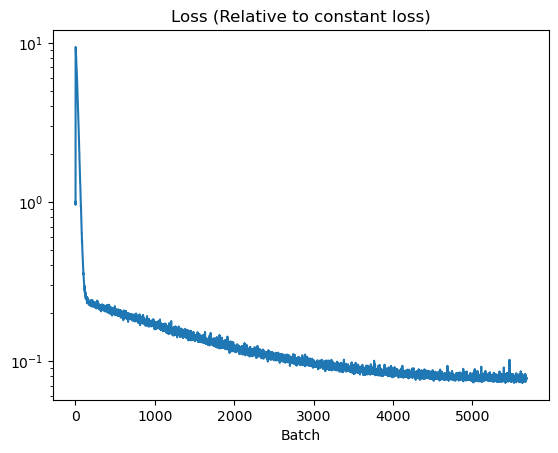

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')

plt.title('Loss (Relative to constant loss)')
plt.xlabel('Batch')

In [8]:
readin_models_path = os.path.join(MODEL_PATH, "readin")
if not os.path.exists(readin_models_path):
    os.makedirs(readin_models_path)

# Switch based on whether you want to save the model
if True: # Save the model
# if False: # Load last model
    # Save the model
    readin = torch.load(os.path.join(readin_models_path, os.listdir(readin_models_path)[-1]))
    print(f"Saving model to {model_path}")
    torch.save(readin,model_path)
else:

    model_path = os.path.join(readin_models_path, os.listdir(readin_models_path)[-1])
    readin = torch.load(model_path)
    print(f"Loaded model from {model_path}")

NameError: name 'model_path' is not defined

In [9]:
# Evaluate the model
readin.eval()
test_losses = []
imgs = []
imgnet_activations_real = []
imgnet_activations_pred = []

with torch.no_grad():
    for minibatch in dl['test']:
        assert len(minibatch) == 1
        item = minibatch[0]
        stim = item['stim'].to(device)
        resp = item['resp'].to(device, dtype=READIN_DTYPE)
        stim_rgb = torch.cat([stim, stim, stim], dim=1)
        target = extractor.get_features(stim_rgb, verbose=False).to(device, dtype=READIN_DTYPE).unsqueeze(0)

        output = readin(resp)

        constant_loss = criterion(torch.zeros_like(output), target).item()
        relative_loss = loss.item() / (constant_loss + 1e-6)

        test_losses.append(relative_loss)
        imgnet_activations_real.append(target)
        imgnet_activations_pred.append(output)
        imgs.append(stim)

        print(f"Loss: {loss.item()} Constant loss: {constant_loss} Relative loss: {relative_loss}")
# .22
print(f"Mean loss: {np.mean(test_losses)}")
print(f"Std loss: {np.std(test_losses)}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (40x8587 and 9395x25088)

In [10]:

output_model = torch.load(RESNET_DECODE_MODEL)
output_model.eval()
for real, recon, pred in zip(imgs, imgnet_activations_real, imgnet_activations_pred):
    plt.figure()
    with torch.no_grad():
        real_img = real
        print(real_img.shape)
        for i in range(real_img.shape[0]):
            plt.figure()
            plt.imshow(real_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            plt.figure()
            plt.imshow(real_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            pred_img = output_model(pred.to('cuda', dtype=torch.float32)).squeeze()
            plt.figure()
            plt.imshow(pred_img[i, ...].squeeze().cpu(), cmap='gray')  # Squeeze to remove extra dimension
            plt.show()